In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pykrx import stock
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score
import FinanceDataReader as fdr
import yfinance as yf
import seaborn as sns
import warnings
warnings.filterwarnings(action = "ignore")

pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_pickle("./수익률.pkl")

In [3]:
df

Ticker,005930,000660,006400,051910,005380,035420,000270,035720,005490,028260,...,003240,069260,005250,004490,001680,105630,005440,020000,003850,057050
2016,0.466541,0.472761,0.045101,-0.200866,0.073587,0.259031,-0.208316,-0.364028,0.559492,-0.054358,...,-0.091012,0.432362,-0.463682,-0.036295,-0.131155,-0.629052,-0.395074,-0.073318,0.218966,0.030507
2017,0.410597,0.614699,0.764037,0.546088,0.111886,0.163627,-0.122321,0.672701,0.326422,0.056049,...,0.391200,0.228877,0.649415,-0.011512,0.098519,0.097116,0.000138,-0.023494,-0.186097,0.125912
2018,-0.217910,-0.153227,0.122390,-0.094183,-0.160182,-0.335799,0.097866,-0.295659,-0.248394,-0.137942,...,0.036796,0.084456,-0.394817,0.048804,-0.049247,-0.175890,0.006191,0.221963,0.120419,-0.144776
2019,0.432101,0.525873,0.168830,-0.023720,0.117914,0.525956,0.369980,0.461674,0.068766,0.087301,...,-0.191319,-0.030211,-0.033132,0.099676,0.001346,-0.021887,-0.144811,-0.073102,0.586521,-0.176113
2020,0.410597,0.614699,0.764037,0.546088,0.111886,0.163627,-0.122321,0.672701,0.326422,0.056049,...,0.391200,0.228877,0.649415,-0.011512,0.098519,0.097116,0.000138,-0.023494,-0.186097,0.125912
2021,-0.017852,0.115581,0.029914,-0.274503,0.089975,0.314840,0.376370,0.429037,0.121062,-0.115225,...,0.327297,-0.025246,-0.595548,0.207924,-0.040946,0.411418,0.046005,0.241690,0.103424,-0.162666


In [4]:
trade = pd.read_csv("./미중 무역현황.csv", encoding="cp949", header=1)
trade.set_index("조회기준", inplace=True)
trade = trade[["수출 점유율", "수입 점유율"]]

In [5]:
# trade = trade.diff()

In [6]:
total = pd.concat([df, trade], axis=1)
total.dropna(axis = 0, inplace=True)

In [7]:
corr_df = total.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
output = corr_df[corr_df.index == "수출 점유율"]
output = output[(output >= 0.5) | (output <=-0.5)].dropna(axis=1)
input = corr_df[corr_df.index == "수입 점유율"]
input = input[(input >= 0.5) | (input <=-0.5)].dropna(axis=1)

## 수출점유율 상관관계

In [18]:
export = output.T.sort_values(["수출 점유율"], ascending=True).iloc[2:]

In [19]:
len(export)

49

## 수입점유율 상관관계

In [25]:
impport = input.T.sort_values(["수입 점유율"], ascending=False).iloc[2:]
impport

,수입 점유율
069260,0.79
009540,0.73
011170,0.70
042670,0.68
004020,0.67
023530,0.61
006360,0.61
016380,0.60
006650,0.57
017670,0.57


In [11]:
volume = pd.read_pickle("./total.pkl")

In [12]:
volume

,삼성전자,SK하이닉스,삼성SDI,LG화학,NAVER,POSCO홀딩스,현대모비스,포스코케미칼,LG전자,SK이노베이션,...,한올바이오파마,KG스틸,녹십자홀딩스,대상,현대그린푸드,한섬,현대홈쇼핑,한세실업,세방전지,보령
date,,,,,,,,,,,,,,,,,,,,,
2015,135205045000000,18780792000000,6680135828651,17334109000000,2141274744000,25607220942253,19079257000000,1175271695215,28368428000000,1667199695000,...,80022525703,1604043536903,47791894602,1648286247805,1476015810000,615393889961,890760608385,1464200813382,956255738545,401350239837
2016,133947204000000,16733111000000,4422860766602,17264845000000,2496498317219,24324933259995,19860589000000,1076455299180,28743246000000,1199714934000,...,82881524071,1542880719243,98335181791,1852714894145,1554226963000,710321856289,961339683153,1421975960308,958982088874,409140006900
2017,161915007000000,29718939000000,5421388951623,20880236000000,2930661324862,28553814576380,19417685000000,1163917965558,31966513000000,3103342788000,...,84230756083,1733421115227,115366470969,2190129354256,1477451922000,765914995234,1021841020147,1354626971623,1108228132369,422721051680
2018,170381870000000,40324651000000,8186909424218,23315318000000,3459014042545,30659425433515,20517169000000,1340983671872,29982010000000,3679762542000,...,91839350940,1750903867403,140083965948,2235924262966,1514615128000,766644344598,973453833250,1316638246722,1165728777090,460401670473
2019,154772859000000,25320755000000,8250811204936,22312561000000,3900013295633,30373510738515,22624741000000,1434507298627,28654467000000,3006128697000,...,108452042397,1688470941497,63553294669,2457055173045,1542730568000,994560575546,1030416792521,1533976204952,1129805364875,524268670098
2020,166311191000000,30524987000000,9101397946638,20830009000000,4126629312584,26509920446184,22954483000000,1524145792626,28435323000000,3808247747000,...,88602270090,2098691005565,78784538818,2604922341877,1512503414000,1194779636319,1084990445012,1657328003744,1077016196453,541445421587
2021,199744705000000,41557337000000,11581771056654,20471044000000,5018667294374,39920200836624,27328555000000,1939523998420,27778047000000,3986068370000,...,101594443691,3208372155531,73934407082,2875271857567,1671200575000,1384773095673,1080403665439,1620351194651,1243923315980,594412561628


[*********************100%***********************]  1 of 1 completed


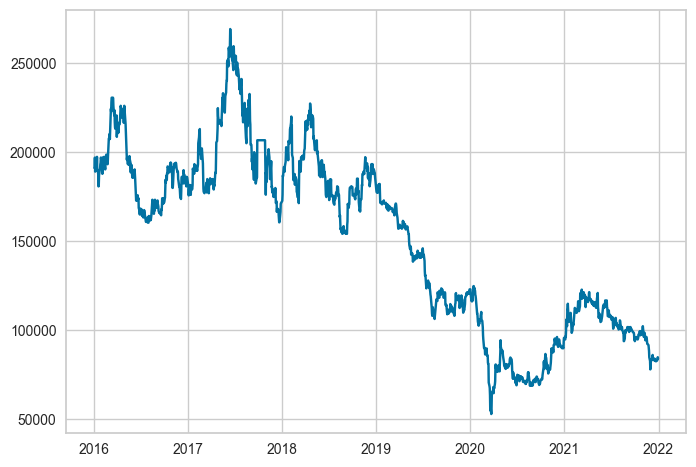

In [51]:
start_date = '2016-01-01'
end_date = '2021-12-31'
close = yf.download("023530.KS", start_date, end_date)["Adj Close"]
plt.plot(close)
plt.show()

In [56]:
df[["051600","000270","086280","011210","020560"]]

Ticker,051600,000270,086280,011210,020560
2016,-0.397742,-0.208316,-0.143384,-0.333285,-0.018419
2017,-0.205654,-0.122321,-0.126126,-0.069992,0.139327
2018,-0.087231,0.097866,0.033330,-0.489106,-0.071049
2019,0.285887,0.369980,0.197895,0.446849,0.510546
2020,-0.205654,-0.122321,-0.126126,-0.069992,0.139327
2021,0.383924,0.376370,-0.026951,0.290442,0.622242
